In [15]:
import os
import torch

# Imposta la variabile d'ambiente per rendere visibile solo la GPU 1
# Nota: "1" significa la GPU con indice 1. Se volessi la GPU 0, metteresti "0".
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Inizializza PyTorch. A questo punto, torch.cuda.device_count() dovrebbe essere 1
# e torch.cuda.current_device() dovrebbe essere 0 (perché è l'unica GPU visibile).
if torch.cuda.is_available():
    print(f"CUDA è disponibile dopo aver impostato CUDA_VISIBLE_DEVICES.")
    print(f"Numero di GPU visibili: {torch.cuda.device_count()}")
    # La GPU selezionata (GPU 1 del sistema) sarà ora l'indice 0 per la tua applicazione
    print(f"La GPU attualmente selezionata è: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda:0") # Ora puoi usare cuda:0
else:
    device = torch.device("cpu")
    print("CUDA non è disponibile. Verrà utilizzata la CPU.")

print(f"Dispositivo scelto per l'esecuzione: {device}")

CUDA è disponibile dopo aver impostato CUDA_VISIBLE_DEVICES.
Numero di GPU visibili: 1
La GPU attualmente selezionata è: NVIDIA GeForce RTX 2080 Ti
Dispositivo scelto per l'esecuzione: cuda:0


In [1]:

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import numpy as np
import pandas as pd

# from src.utils.hf_utils import download_weights
# from src.utils.vit_config import inizialize_model
from src.data.dataset import PatchFromH5Dataset, stratified_split, plot_class_distributions
from src.rl.train import ModelTrainer, TrainingArguments

from src.rl.modelling import ViT_UCB_Pruning


/home/vcivale/UNI_UCB2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 8
NUM_EPOCHS = 70

In [3]:
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest/patches/patches/',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

In [4]:
labels = dataset.labels

In [6]:
# Crea un DataFrame con indici e label
df = pd.DataFrame({
    "index": np.arange(len(labels)),
    "label": labels
})

# Trova il numero di elementi della classe minoritaria
min_count = df["label"].value_counts().min()

# Per ogni classe, seleziona min_count elementi a caso
undersampled_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)
)

# Mischia gli indici
undersampled_indices = undersampled_df["index"].sample(frac=1, random_state=42).tolist()

# Crea il subset bilanciato
balanced_dataset = Subset(dataset, undersampled_indices)

print(f"Campioni per classe: {min_count}")
print(f"Dimensione dataset bilanciato: {len(balanced_dataset)}")

Campioni per classe: 1181
Dimensione dataset bilanciato: 31887


/tmp/ipykernel_3221513/3052705917.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [7]:
train_idx, val_idx, test_idx = stratified_split(balanced_dataset, test_size=0.3, val_size=0.3, random_state=42)

In [9]:
train_dataset = Subset(balanced_dataset, train_idx)
val_dataset = Subset(balanced_dataset, val_idx)
test_dataset = Subset(balanced_dataset, test_idx)

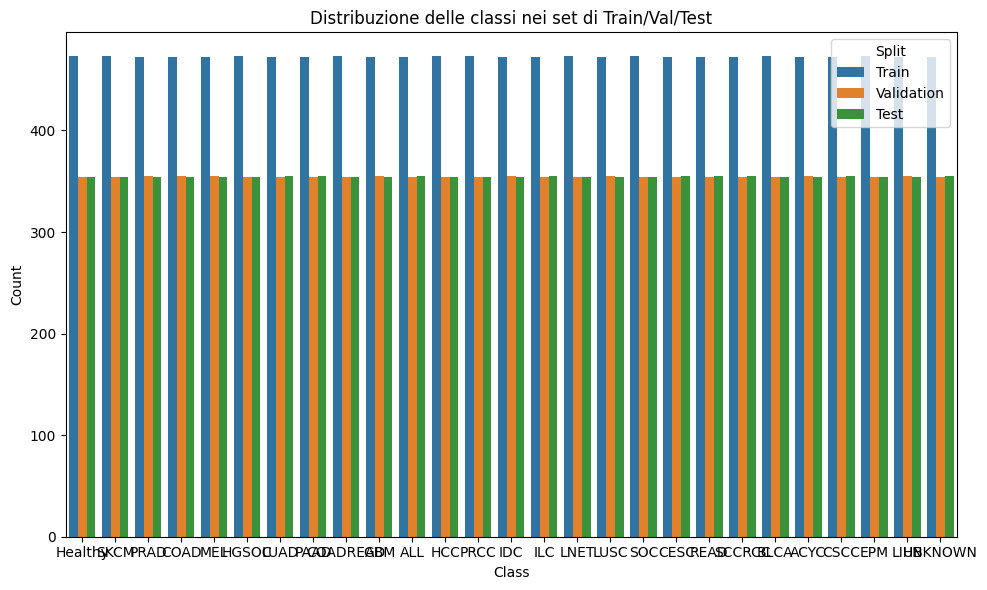

In [11]:
plot_class_distributions(train_dataset, val_dataset, test_dataset, full_dataset=dataset)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=16, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)

In [13]:
labels_num = len(dataset.labels)

print(f"Number of classes: {labels_num}")
model = ViT_UCB_Pruning(model_name="hf-hub:MahmoodLab/uni", pretrained=True, n_classes=labels_num)

Number of classes: 1848133
Loading source model 'hf-hub:MahmoodLab/uni'...


KeyboardInterrupt: 

In [ ]:
args = TrainingArguments(
        output_dir="./results",
        run_name="ViT-L-UCB-Pruning-run1",
        num_train_epochs=NUM_EPOCHS,
        learning_rate=0.1,
        train_batch_size=8,
        eval_batch_size=8,
        max_steps=20000,
        warmup_steps=500,
        eval_steps=92406,
        save_steps=92406,
        logging_steps=2500,
        fp16=False,
        report_to="wandb", 
        early_stopping_patience=3, # Interrompi dopo 3 valutazioni senza miglioramento
        early_stopping_metric="eval/loss", # Oppure monitora la loss (un valore più basso è meglio)
    )


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
# The scheduler needs max_steps, so we calculate it first
num_steps = args.num_train_epochs * (len(train_loader) // args.gradient_accumulation_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_steps)

In [11]:

trainer = ModelTrainer(
        model=model,
        args=args,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        test_dataloader=test_loader,
        class_names=dataset.class_names,           # Pass the class names
        optimizers=(optimizer, scheduler) 
    )

/home/vcivale/UNI_UCB2/src/rl/train.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.args.fp16)
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


07/19/2025 12:03:50 - INFO - src.rl.train - Early stopping enabled: monitoring 'eval/loss' with patience 3 and threshold 0.0001.


In [ ]:
trainer.train()

07/19/2025 12:03:50 - INFO - src.rl.train - ***** Running training *****
07/19/2025 12:03:50 - INFO - src.rl.train -   Num Epochs = 1
07/19/2025 12:03:50 - INFO - src.rl.train -   Total optimization steps = 20000
Epoch 1/1:   0%|          | 0/92406 [00:00<?, ?it/s]/home/vcivale/UNI_UCB2/src/rl/train.py:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16):
Epoch 1/1:   0%|          | 442/92406 [02:43<8:42:38,  2.93it/s, loss=1.8442, lr=8.84e-02] 